In [84]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from typing import Optional, Union, List

# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [85]:
from qiskit import pulse, transpile
from qiskit.circuit import ParameterVector, QuantumCircuit, QuantumRegister, Gate
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, gate_map, plot_gate_map
from qiskit.visualization.pulse_v2 import IQXDebugging
from qiskit.providers import QubitProperties, Backend, BackendV1, BackendV2
from qiskit_dynamics import DynamicsBackend, Solver

import os
import sys
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)
from quantumenvironment import QuantumEnvironment
from qconfig import QiskitConfig
from helper_functions import select_optimizer, generate_model, get_control_channel_map, get_solver_and_freq_from_backend

## PennyLane Pulse Level Evolution of a Hamiltonian

In [86]:
def f1(p, t):
    # polyval(p, t) evaluates a polynomial of degree N=len(p)
    # i.e. p[0]*t**(N-1) + p[1]*t**(N-2) + ... + p[N-2]*t + p[N-1]
    return jnp.polyval(p, t)

def f2(p, t):
    return p[0] * jnp.sin(p[1] * t)

Ht = f1 * qml.PauliX(0) + f2 * qml.PauliY(1)

This constructs a ``ParametrizedHamiltonian``. Note that the ``callable`` functions ``f1`` and ``f2`` are expected to have the fixed signature (p, t). When calling the ``ParametrizedHamiltonian``, a tuple or list of the parameters for each of the functions is passed in the same order the Hamiltonian was constructed.

In [87]:
p1 = jnp.ones(5)              # parameters for f1
p2 = jnp.array([1.0, jnp.pi]) # parameters for f2
t = 0.5                       # some fixed point in time
print(Ht((p1, p2), t))        # order of parameters p1, p2 matters

(1.9375*(PauliX(wires=[0]))) + (1.0*(PauliY(wires=[1])))


In [88]:
coeffs = [1.0] * 2
coeffs += [lambda p, t: jnp.sin(p[0] * t) + jnp.sin(p[1] * t) for _ in range(3)]
ops = [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(2)]
ops += [qml.PauliZ(i) for i in range(3)]

Ht = qml.dot(coeffs, ops)

# random coefficients
key = jax.random.PRNGKey(777)
subkeys = jax.random.split(key, 3) # create list of 3 subkeys
params = [jax.random.uniform(subkeys[i], shape=[2], maxval=5) for i in range(3)]
print(Ht(params, 0.5))

((1.0*(PauliX(wires=[0]) @ PauliX(wires=[1]))) + (1.0*(PauliX(wires=[1]) @ PauliX(wires=[2])))) + (((1.4456867348869746*(PauliZ(wires=[0]))) + (1.823824746247098*(PauliZ(wires=[1])))) + (1.8206871129031437*(PauliZ(wires=[2]))))


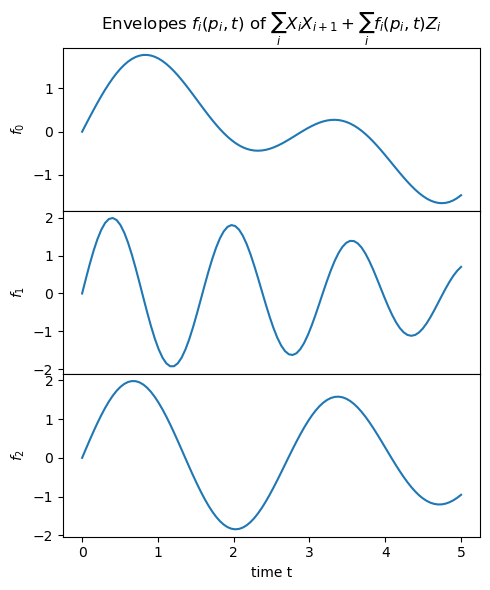

In [89]:
ts = jnp.linspace(0.0, 5.0, 100)
fs = Ht.coeffs_parametrized
ops = Ht.ops_parametrized
n_channels = len(fs)
fig, axs = plt.subplots(nrows=n_channels, figsize=(5, 2 * n_channels), gridspec_kw={"hspace": 0})
for n in range(n_channels):
    ax = axs[n]
    ax.plot(ts, fs[n](params[n], ts))
    ax.set_ylabel(f"$f_{n}$")
axs[0].set_title(f"Envelopes $f_i(p_i, t)$ of $\sum_i X_i X_{{i+1}} + \sum_i f_i(p_i, t) Z_i$")
axs[-1].set_xlabel("time t")
plt.tight_layout()
plt.show()

In [90]:
dev = qml.device("default.qubit.jax", range(4))

ts = jnp.array([0.0, 3.0])
H_obj = sum([qml.PauliZ(i) for i in range(4)])


@jax.jit
@qml.qnode(dev, interface="jax")
def qnode(params):
    qml.evolve(Ht)(params, ts)
    return qml.expval(H_obj)


print(qnode(params))

0.017290111149849796


## Qiskit Pulse

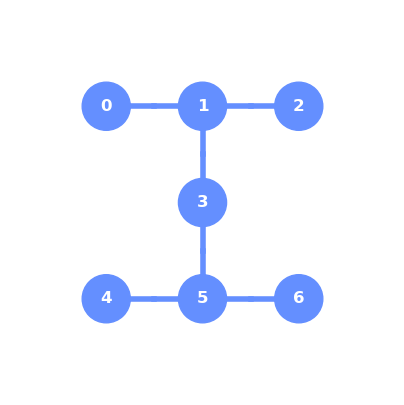

In [91]:
fake_backend = FakeJakarta() # mimics the bahaviour of a 7-qubits hardware
fake_backend_v2 = FakeJakartaV2() # mimics the bahaviour of a 7-qubits hardware

plot_gate_map(fake_backend)

In [104]:
# List of addressed qubits
physical_qubits = [3, 5]
sampling_Paulis = 200
N_shots = 10  # Number of shots for sampling the quantum computer for each action vector
n_actions = 31  # Choose how many control parameters in pulse/circuit parametrization
abstraction_level = 'pulse' # Choose at which abstraction level the circuit ansatz is written
estimator_options = {'resilience_level': 0}

In [105]:
control_channel_map = get_control_channel_map(fake_backend, qubit_tgt_register=physical_qubits)

dynamics_options = {'seed_simulator': None, #"configuration": fake_backend.configuration(),
                    'control_channel_map': control_channel_map,
                    # Control channels to play CR tones, should match connectivity of device
                    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax":fake_backend_v2.dt}
                    }
dynamics_backend = DynamicsBackend.from_backend(fake_backend, subsystem_list=physical_qubits, **dynamics_options)


In [106]:
def custom_cx_pulse_schedule(backend: Backend, physical_qubits: list, params: ParameterVector,
                             default_params: dict, cx_instructions: pulse.Schedule):
    """
    Define parametrization of the pulse schedule characterizing the target gate
        :param backend: IBM Backend on which schedule shall be added
        :param qubit_tgt_register: Qubit register on which
        :param params: Parameters of the Schedule
        :param default_schedule:  baseline from which one can customize the pulse parameters

        :return: Parametrized Schedule
    """
    cx_pulses = np.array(cx_instructions.instructions)[:,1]
    control_qubit, target_qubit = physical_qubits
    index = 0
    duration_variability = 0
    # Look here for the pulse features to specifically optimize upon, for the cx gate here, 
    with pulse.build(backend=backend, name='param_schedule', default_alignment="left") as parametrized_schedule:
        for instruction in cx_pulses:
            if isinstance(instruction, pulse.ShiftPhase):
                pulse.shift_phase(instruction.phase+params[index], instruction.channel, instruction.name)
                index += 1
            elif instruction.pulse.pulse_type == 'GaussianSquare':
                pulse_params = instruction.pulse.parameters
                for key in ("amp", "duration", "angle"):
                    param = params[index] if key != "duration" else pulse.builder.seconds_to_samples(duration_variability * params[index])
                    pulse_params[key]+= param
                    index += 1

        return parametrized_schedule

In [107]:
# Pulse gate ansatz

def apply_cx_parametrized_circuit(qc: QuantumCircuit, params: Optional[ParameterVector]=None, tgt_register: Optional[QuantumRegister]=None):
    """
    Apply a parametrized CX (CNOT) gate to a Quantum Circuit.

    This function adds a parametrized CX gate to a given Quantum Circuit (QC). The gate
    is specified by a set of parameters, which allows for flexibility in the gate's
    behavior. The resulting gate is added to the target quantum register in the provided QC.

    Parameters:
    qc (QuantumCircuit): The Quantum Circuit to which the parametrized CX gate will be added.
    params (Optional[ParameterVector]): Optional. A ParameterVector specifying the parameters
        for the parametrized CX gate. If not provided, a default set of parameters will be used.
    tgt_register (Optional[QuantumRegister]): Optional. The target quantum register to which
        the parametrized CX gate will be applied. If not provided, the default quantum register
        of the QC will be used.
    """


    # qc.num_qubits
    global n_actions, backend, physical_qubits, default_params, cx_instructions
    
    # x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit_tgt_register,)).instructions[0][1].pulse
    if params is None:
        params = ParameterVector('theta', n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]
    # original_calibration = backend.instruction_schedule_map.get(target["name"])

    # Define a custom parametrized gate named "custom_cx" with 2 qubits and using the specified parameters.
    parametrized_gate = Gate("custom_cx", 2, params=params.params)
    # Generate a parametrized pulse schedule for the custom CX gate using provided parameters,
    # default parameters, and CX instructions.
    parametrized_schedule = custom_cx_pulse_schedule(backend=backend, physical_qubits=physical_qubits,
                                                    params=params, default_params=default_params, cx_instructions=cx_instructions)

    # Add the parametrized schedule as a calibration for the custom CX gate on the specified physical qubits.
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    # Append the custom parametrized CX gate to the target quantum register in the provided Quantum Circuit (QC).
    qc.append(parametrized_gate, tgt_register)

In [108]:
def determine_cr_params(backend: Backend, qubit_tgt_register: list, basis_gate="cx"):
    """
    Determine control and target pulse parameters for a given CNOT gate (CX) on a specified backend.

    This function retrieves the control and target pulse parameters (the CNOT gate is a 2-qubit gate 
    with one control and one target qubits) associated with a CNOT (CX) gate instruction on a quantum backend.
    It is designed to work with backends that support IBM Quantum Experience (Qiskit) and Quantum OpenQASM.

    Parameters:
    backend (Backend): The quantum backend on which to determine the parameters.
    qubit_tgt_register (list): A list of qubit indices for the target register.
    basis_gate (str): The basis gate to consider when determining parameters (default is "cx").

    Returns:
    tuple: A tuple containing the following three elements:
        - params (dict): A dictionary containing the control and target pulse parameters
          of the CNOT gate, including 'amp', 'amp_t', 'angle', 'angle_t', 'duration',
          'sigma', and 'width'.
        - cx_instructions (InstructionScheduleMap): The instruction schedule map for the
          specified backend and basis gate.
        - cx_pulses (numpy.ndarray): An array of CNOT gate pulses extracted from the
          instruction schedule map.
    """
    
    if isinstance(backend, BackendV1):
        instruction_schedule_map = backend.defaults().instruction_schedule_map
    else:
        instruction_schedule_map = backend.target.instruction_schedule_map()
    cx_instructions = instruction_schedule_map.get(basis_gate, qubits=qubit_tgt_register)
    cx_pulses = np.array(cx_instructions.instructions)[:,1]
    control_pulse = target_pulse = None
    for pulse in list(cx_pulses):
        name = str(pulse.name)
        if not name.find("CR90p_d") == -1:
            target_pulse = pulse.pulse
        if not name.find("CR90p_u") == -1:
            control_pulse = pulse.pulse
        
    params = {
        "amp": control_pulse.amp,
        "amp_t": target_pulse.amp,
        "angle": control_pulse.angle,
        "angle_t": target_pulse.angle,
        "duration": control_pulse.duration,
        "sigma": control_pulse.sigma,
        "width": control_pulse.width
    }
    return params, cx_instructions, cx_pulses

Gate Pulse Sequence for a given backend

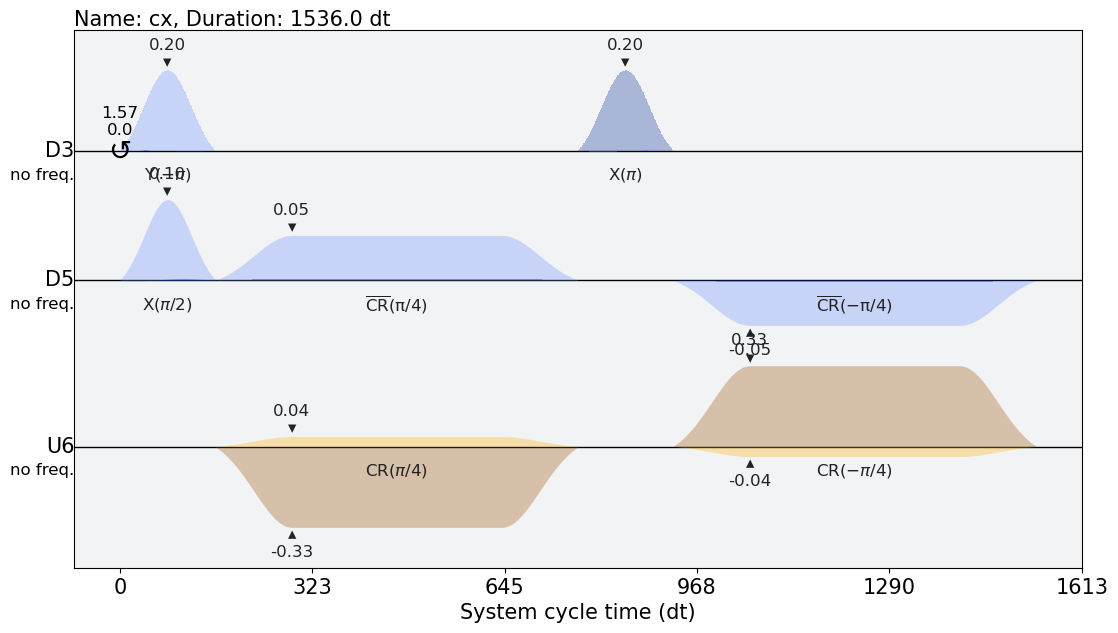

In [111]:
default_params, cx_instructions, cx_pulses = determine_cr_params(backend=fake_backend, qubit_tgt_register=tgt_register, basis_gate='cx')
cx_instructions.draw(style=IQXDebugging())

Create a 2-qubit quantum circuit and add a parameterized gate with parameters $\theta$

In [112]:
# backend = fake_backend

qc = QuantumCircuit(2)
apply_cx_parametrized_circuit(qc)

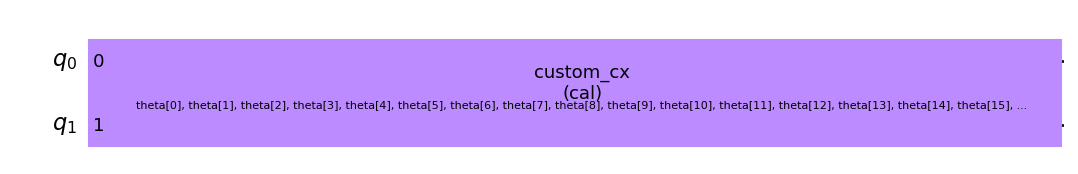

In [113]:
qc.draw('mpl')